# Elevation Covariate

Read elevation data by a bounding box tile for stacking with other covariates in analysis.
Initial version uses SRTM v3 available as Cloud Optimized Geotiffs in MAAP.


1. Get bbox of tile
2. Buffer/extend bbox at min 1 pixel (can be more, no prob)3
3. Read the elev data
4. Write elevation data to /tmp in order to read back in as a gdal dataset that gdal.DEMProcessing wants.
5. Clip and write_band for elev
6. Compute the 3 covars in memory with for loop; for covar in covars: calc, clip, write_band
    a. use GDAL DEMProcessing or gdaldem via python os.subprocess.run()


In [ ]:
if True:
    #only run this block if needed in a new workspace, TODO: add to conda env.yml
    #%conda install -yq -c conda-forge rasterio geopandas folium rio-cogeo rio-tiler importlib_resources
    %pip install -U geopandas rio-cogeo rio-tiler importlib_resources rasterio folium importlib_resources numpy

    # TODO: find out why rio-tiler doesn't always pull importlib_resources

In [8]:
import sys
import json
import os
from pprint import pprint

from osgeo import gdal

import boto3

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import numpy.ma as ma
from pyproj import Proj, Transformer

import geopandas as gpd
import shapely as shp
import folium
from shapely.geometry import box
from fiona.crs import from_epsg
import rasterio as rio
from rasterio.transform import Affine
from rasterio.session import AWSSession 
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import * #TODO: limit to specific needed modules
from rasterio.merge import merge
from rasterio import windows
#from rasterio.io import MemoryFile
from rasterio.crs import CRS
#from rasterio.vrt import WarpedVRT
#from rio_cogeo.profiles import cog_profiles
#from rio_tiler.utils import create_cutline
#from rio_cogeo.cogeo import cog_translate

from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

from CovariateUtils import write_cog, get_index_tile
from CovariateUtils_topo import *

In [9]:
RUN_DPS = False
if False:
    %conda install -yq -c conda-forge folium

# Set the boreal tiles index vector and get a test tile

In [17]:
# Identify a list of tiles you will want to DPS over
# Read the boreal tile index file
boreal_tile_index_path = '/projects/my-public-bucket/boreal_grid_albers90k_gpkg.gpkg'
boreal_tiles_layer = 'grid_boreal_albers90k_gpkg'
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

#INPUT_TILE_NUM_LIST = [30542, 30543, 30821, 30822, 30823]
boreal_tile_index_subset = boreal_tile_index.to_crs(4326).cx[-170:-50, 50:75]

# Boreal NA tiles: need just a list of tile_ids
INPUT_TILE_NUM_LIST = boreal_tile_index_subset['layer'].astype(int).tolist()
print(len(INPUT_TILE_NUM_LIST))
# Identify the tile number you want to map
test_tile_id = INPUT_TILE_NUM_LIST[90] #30542
print(test_tile_id) 

1305
797


## Map the test tile

In [11]:

boreal_geojson = '/projects/my-public-bucket/boreal.geojson'
boreal = gpd.read_file(boreal_geojson)
ecoboreal_geojson = '/projects/my-public-bucket/Ecoregions2017_boreal_m.geojson'
ecoboreal = gpd.read_file(ecoboreal_geojson)

# Reproject
p1, p2, clat, clon = [50, 70, 40, 160]
proj_str_aea = '+proj=aea +lat_1={:.2f} +lat_2={:.2f} +lat_0={:.2f} +lon_0={:.2f}'.format(p1, p2, clat, clon)
ecoboreal_aea = ecoboreal.to_crs(proj_str_aea)
# Apply a buffer
ecoboreal_aea_buf = ecoboreal_aea["geometry"].buffer(1e5)
# Go back to GCS
ecoboreal_buf = ecoboreal_aea_buf.to_crs(boreal_tile_index.crs)

# Tiles for north america
# Subsetting this tiles file down in these ways makes the map fail, or just doesnt result in tiles
if False:
    boreal_tile_index_subset = boreal_tile_index.intersection(ecoboreal_buf)
elif False:
    boreal_tile_index_subset = boreal_tile_index.cx[-180:180, 50:75]
elif False:
    boreal_tile_index_subset = boreal_tile_index.set_crs(boreal.crs, allow_override=True).intersection(boreal)
else:
    boreal_tile_index_subset = boreal_tile_index.iloc[(test_tile_id-1):test_tile_id] 

# This is fine for a single tile
TEST_tile_index = get_index_tile(boreal_tile_index_path, test_tile_id, buffer=120, layer = boreal_tiles_layer)
print("Test tile: ", test_tile_id)
print(*TEST_tile_index['bbox_4326'])

# Read the copernicus index file
cop30dem_geojson = '/projects/my-public-bucket/dem30m_tiles.geojson'
cop30dem = gpd.read_file(cop30dem_geojson)

# DEM tiles for NA
cop30dem_boreal = cop30dem.cx[-170:-50, 50:75]

m=None
ecoboreal_style = {'fillColor': 'orange', 'color': 'orange'}
boreal_style = {'fillColor': 'green', 'color': 'green'}
boreal_subset_style = {'fillColor': 'red', 'color': 'red'}

m = folium.Map(
        # Zoom to a center
        location=[TEST_tile_index['bbox_4326'][1],TEST_tile_index['bbox_4326'][0]],
        #location=[boreal_tile_index_subset['geometry'].centroid.y, boreal_tile_index_subset['geometry'].centroid.x],
        tiles='Stamen Terrain',
        zoom_start=4,
        )
print("Showing map of boreal index tiles...")
#folium.GeoJson(cop30dem_boreal, name="DEM index tiles").add_to(m)
folium.GeoJson(ecoboreal_aea_buf, name="Boreal extent from Ecoregions", style_function=lambda x:ecoboreal_style).add_to(m)
folium.GeoJson(boreal, name="Boreal extent", style_function=lambda x:boreal_style).add_to(m)
folium.GeoJson(boreal_tile_index, name="Boreal index tiles").add_to(m)
folium.GeoJson(boreal_tile_index_subset, name="Boreal index tiles subset", style_function=lambda x:boreal_subset_style).add_to(m)

# Show map
m

Test tile:  797
-65.65851801580362 49.85216888670058 -64.22798355970222 50.766873225824455
Showing map of boreal index tiles...


In [12]:
if False:
    tindex = '/projects/tile-index2.shp'
    tiles = gpd.read_file(tindex).set_crs(5069)

    # Reproject
    p1, p2, clat, clon = [50, 70, 40, 160]
    proj_str_aea = '+proj=aea +lat_1={:.2f} +lat_2={:.2f} +lat_0={:.2f} +lon_0={:.2f}'.format(p1, p2, clat, clon)
    tiles_aea = tiles.to_crs(proj_str_aea)


    longitude = -98.04
    latitude = 54.36

    m = folium.Map(location=[latitude,longitude],
            tiles='Stamen Terrain',
            zoom_start=4
            )

    folium.GeoJson(tiles_aea, name="North America Tiles").add_to(m)
    m

#### Get the input tiles list

In [19]:
# check which files exist so we can omit them and not run again

topo_out = '/projects/my-private-bucket/dps_output/do_topo_stack_3-1-5_ubuntu'

completed = []

for dir, subdir, files in os.walk(topo_out):
    for fname in files:
        if fname.endswith("_stack.tif"):
            completed.append(fname.split('_')[1])
            
print(len(completed))

2220


In [21]:
RUN_DPS = True
if False:
    # Notes:
    # example: look here for output:
    # /projects/jabba/dps_output/do_topo_stack_3-1-5_ubuntu/master/2021/05/17/13/55/04/237357/Copernicus_30440_covars_cog_topo_stack.tif

    # Test tiles
    #INPUT_TILE_NUM_LIST = [30542, 30543, 30821, 30822, 30823]

    # NA tiles
    # Read the boreal tile index file
    #in_tile_fn='/projects/maap-users/alexdevseed/boreal_tiles.gpkg'
    in_tile_fn = boreal_tile_index_path #'/projects/shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg'
    boreal_tile_index = gpd.read_file(in_tile_fn)
    boreal_tile_index_subset = boreal_tile_index.to_crs(4326).cx[-170:-50, 50:75]
    #boreal_tile_index_subset = boreal_tile_index.to_crs(4326).cx[-120:-119, 60:61]
    # Boreal NA tiles: need just a list of tile_ids
    INPUT_TILE_NUM_LIST = boreal_tile_index_subset['layer'].astype(int).tolist()
    #INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[100:151]
    print(len(INPUT_TILE_NUM_LIST))
    print(np.min(INPUT_TILE_NUM_LIST))
    print(np.max(INPUT_TILE_NUM_LIST))

    #INPUT_TILE_NUM_LIST = [30542, 30543, 30821, 30822, 30823] 
    #INPUT_TILE_NUM_LIST = [3848]


INPUT_TILE_NUM_LIST = boreal_tile_index['layer'].astype(int).tolist()

INPUT_TILE_NUM_LIST = np.setdiff1d(INPUT_TILE_NUM_LIST, completed)
print(INPUT_TILE_NUM_LIST)
print(len(INPUT_TILE_NUM_LIST))

INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[:3000]
print('running ' + str(len(INPUT_TILE_NUM_LIST)))

[   2    3    7 ... 4555 4556 4557]
2337
running 2337


# Run a DPS of topo tiles

In [22]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Run this after you have committed to both github and gitlab and registered the MAS alg
if RUN_DPS:
    for g in range(len(INPUT_TILE_NUM_LIST)):
        in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg',
                         'in_tile_num': INPUT_TILE_NUM_LIST[g],
                         'tile_buffer_m': 120,
                         'in_tile_layer': 'grid_boreal_albers90k_gpkg',
                         'topo_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson',
        }
        job_submit_result = maap.submitJob(
                                    identifier="topo_stack_runs",
                                    algo_id="do_topo_stack_3-1-5_ubuntu",
                                    version="ops",
                                    username="nathanmthomas",
                                    # Args that match yaml
                                    **in_param_dict
        )
        if g == 1:
            print(job_submit_result)
        if g == 100:
            print (job_submit_result)
        if g == 1000:
            print (job_submit_result)
        if g == 2000:
            print (job_submit_result)
        if g == 3000:
            print (job_submit_result)
        if g == 4000:
            print (job_submit_result)
        if g == len(INPUT_TILE_NUM_LIST):
            print (job_submit_result)
            print ('done!')
        
            

{'status': 'success', 'http_status_code': 200, 'job_id': 'ef6babdb-59d7-4baf-9bb3-f3465b19c888'}
{'status': 'success', 'http_status_code': 200, 'job_id': 'db610875-dbe9-4f02-91ed-0724884d8c2d'}
{'status': 'success', 'http_status_code': 200, 'job_id': 'fc232245-930d-4cbf-b6d5-47be330ca252'}
{'status': 'success', 'http_status_code': 200, 'job_id': 'ca3fa302-ff6b-4716-b99e-32a1e26ce376'}


In [18]:
# Test tiles
#INPUT_TILE_NUM_LIST = [30542, 30543, 30821, 30822, 30823]

# NA tiles
# Read the boreal tile index file
#in_tile_fn='/projects/maap-users/alexdevseed/boreal_tiles.gpkg'
boreal_tile_index = gpd.read_file(in_tile_fn)
boreal_tile_index_subset = boreal_tile_index.to_crs(4326).cx[-170:-50, 50:75]
#boreal_tile_index_subset = boreal_tile_index.to_crs(4326).cx[-120:-119, 60:61]
# Boreal NA tiles: need just a list of tile_ids
INPUT_TILE_NUM_LIST = boreal_tile_index_subset['layer'].astype(int).tolist()
INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[1:10]
print(INPUT_TILE_NUM_LIST)

[389, 420, 421, 451, 452, 453, 454, 455, 456]


### 1. Get the bbox of the tile

In [21]:
# Get bbox extent

bbox_ID = 30542 #old 40349 #ID to match covar testing
bbox_ID = 30543
bbox_ID = 30438 #new testing tile for coastal
bbox_ID = INPUT_TILE_NUM_LIST[0]

# Siberia
#bbox_ID = 18821 
#boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles.gpkg'

tile_index = get_index_tile(boreal_tile_index_path, bbox_ID, buffer=120, layer = boreal_tiles_layer)
print(tile_index['bbox_4326_buffered'])

# Set the final output projection
print(tile_index['tile_crs'].to_dict())

# Set the final tile clip
tile_index['geom_orig']

[-51.71371496523002, 49.18540830292919, -50.11101722624615, 50.226250208730086]
{'proj': 'aea', 'lat_0': 40, 'lon_0': 180, 'lat_1': 50, 'lat_2': 70, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


layer                                           geometry
357  358.0  POLYGON ((4508522.000 7623304.000, 4598522.000...

Use the bbox to find DEMs

In [67]:
# Intersect DEM index file with the bbox tile
# Read the copernicus index file
cop30dem_geojson = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
cop30dem = gpd.read_file(cop30dem_geojson)
selection = cop30dem.loc[cop30dem.intersects(tile_index['geom_4326_buffered'].iloc[0])]
print(selection.head())
tile_index["geom_4326"].bounds.iloc[0].to_list()

                                            id  \
4205  Copernicus_DSM_COG_10_N67_00_W165_00_DEM   
4206  Copernicus_DSM_COG_10_N67_00_W164_00_DEM   

                                                    key  \
4205  Copernicus_DSM_COG_10_N67_00_W165_00_DEM/Coper...   
4206  Copernicus_DSM_COG_10_N67_00_W164_00_DEM/Coper...   

                                                     s3  \
4205  s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...   
4206  s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...   

                                               geometry  
4205  POLYGON ((-165.00028 67.00014, -165.00028 68.0...  
4206  POLYGON ((-164.00028 67.00014, -164.00028 68.0...  


[-164.19506368839194, 67.23726969134741, -163.3413296463604, 67.55994305798546]

### 2. Buffer/extend bbox

In [24]:
# Reformat bbox
#bbox_list =  [float(value) for value in converted_in_bbox.split(',')]
bbox_list = tile_index["bbox_4326"]
print(bbox_list)
# Elevation covar calc will require consideration of tile edges. We want seemlessness across adjacent tiles
# To handle this, use this buffered bbox to extract elevation data, process it to the covars, then clip by original bbox
bbox_buffered = tile_index['bbox_4326_buffered']
# TODO: Probably need a 'bbox_buffered_list' from the above geometry...
print(bbox_buffered)

# Get centroid of bbox
#center = shp.geometry.box(*bbox_list).centroid
center = tile_index["geom_orig"].centroid.to_crs(4326)

m = folium.Map(
    # Zoom to center
    #location=[center.y,center.x],
    # Zoom to corner
    location=[bbox_list[1], bbox_list[2]],
    tiles="cartodbpositron",
    zoom_start=5,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}
bbox_buf_style = {'fillColor': '#fdae61', 'color': '#fdae61'}

#folium.GeoJson(selection, name="tiles").add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_buffered), 
               name="bbox_buf",
               style_function=lambda x:bbox_buf_style).add_to(m)
m

[-51.712063359305716, 49.18648871205133, -50.11268808466945, 50.22517318144476]
[-51.71371496523002, 49.18540830292919, -50.11101722624615, 50.226250208730086]


### Read the elevation data (for the bbox)

For each result read the subwindow. After reading all the subwindows, merge them together as a single  array. 

In [68]:
# Set up and aws session
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
aws_session = AWSSession(boto3.Session())
# Get the s3 urls to the granules
file_s3 = selection["s3"].to_list()
file_s3.sort()
#print("The DEM filenames for the bbox:\n", '\n'.join(file_s3))
print("The DEM filenames for the bbox:\n", *file_s3)


The DEM filenames for the bbox:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N67_00_W164_00_DEM/Copernicus_DSM_COG_10_N67_00_W164_00_DEM.tif s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N67_00_W165_00_DEM/Copernicus_DSM_COG_10_N67_00_W165_00_DEM.tif


In [19]:
if False:
    # prove that we can read the aws files, an overview should be faster
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rio.Env(aws_session):
        with rio.open(file_s3[0], 'r') as src:
            # List of overviews from biggest to smallest
            oviews = src.overviews(1)

            # Retrieve the smallest thumbnail
            oview = oviews[1]
            thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    show(thumbnail)

# Create a mosaic from all the images
with rio.Env(aws_session):
#    sources = [rio.open(raster, 'r') for raster in file_s3]    
    sources = [get_sources(raster, tile_index['geom_orig_buffered'].bounds.iloc[0].to_list(), tile_index['tile_crs'], tile_index['tile_crs']) for raster in file_s3]
    
# Merge the source files
#print(tile_index['bbox_4326_buffered'])
#mosaic, out_trans = merge(sources, bounds = tile_index['bbox_4326_buffered'])

#show(mosaic, cmap = 'terrain')

In [75]:
# New method to read in data in final projection
from typing import List
from rio_tiler.models import ImageData
from rio_tiler.mosaic import mosaic_reader

def reader(src_path: str, bbox: List[float], epsg: CRS, dst_crs: CRS, height: int, width: int) -> ImageData:
    with COGReader(src_path) as cog:
        return cog.part(bbox, bounds_crs=epsg, max_size=None, dst_crs=dst_crs, height=height, width=width)

def get_shape(bbox, res=30):
    left, bottom, right, top = bbox
    width = int((right-left)/res)
    height = int((top-bottom)/res)
    return height,width

bbox = tile_index['geom_orig_buffered'].bounds.iloc[0].to_list()
height, width = get_shape(bbox, 30)

img = mosaic_reader(file_s3, reader, bbox, tile_index['tile_crs'], tile_index['tile_crs'], height, width) 
mosaic = (img[0].as_masked())
m_trans =  rasterio.transform.from_bounds(*bbox, width, height)


In [76]:
mosaic.shape

(1, 1008, 1008)

In [23]:
topo_stack_names = ["elevation","slope","tsri","tpi", "slopemask"]
print('\nReturning re-projected points with {} new raster value column: {}'.format(len(topo_stack_names), topo_stack_names))
for i,bandname in enumerate(topo_stack_names):
    print( bandname,i)


Returning re-projected points with 5 new raster value column: ['elevation', 'slope', 'tsri', 'tpi', 'slopemask']
elevation 0
slope 1
tsri 2
tpi 3
slopemask 4


### Write Results as Cloud Optimized Geotiff
Write elevation data to /tmp in order to read back in as a gdal dataset (that gdal.DEMProcessing wants) in order to calc that remaining topo covars.

In [77]:
%%time

res = 30

# Writing tmp elevation COG so that we can read 

# TODO: Reproject so that covars are more accurate
# TODO: format outname correctly to coincide with Landsat covars

data_path = "/projects/tmp"
if (not os.path.isdir(data_path)): os.mkdir(data_path)
tileid = '_'.join(['Copernicus', str(bbox_ID)])
ext = "covars_cog.tif"  
dem_cog_fn = os.path.join(data_path, "_".join([tileid, ext]))

#write_cog(mosaic, dem_cog_fn, sources[0].crs, out_trans, ["elevation"], out_crs=tile_index['tile_crs'], resolution=(res, res))
write_cog(mosaic, dem_cog_fn, tile_index['tile_crs'], m_trans, ["elevation"], out_crs=tile_index['tile_crs'], resolution=(res, res))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  from ipykernel import kernelapp as app
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/584ff0ff-4a90-4e44-a3c9-b7f43b3fcc1d/584ff0ff-4a90-4e44-a3c9-b7f43b3fcc1d.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/tmp/Copernicus_30438_covars_cog.tif


Orig stack shape:  (1, 1008, 1008)
Output resolution:  (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 1008, 'height': 1008, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.000000000000004, 0.0, 668402.0,
       0.0, -30.000000000000004, 3153424.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
Image written to disk:  /projects/tmp/Copernicus_30438_covars_cog.tif
CPU times: user 38

True

### Derive topographic covariates from DEM
This step uses gdaldem to access the DEM COG, calc a topo covar, and write each covariate to a separate COG

In [78]:
%%time
topo_stack_cog_fn = os.path.join(os.path.splitext(dem_cog_fn)[0] + '_topo_stack.tif')
print(topo_stack_cog_fn)

topo_stack, topo_stack_names = make_topo_stack_cog(dem_cog_fn, topo_stack_cog_fn, tile_index, res)

print("Type: ", topo_stack.dtype)


/projects/tmp/Copernicus_30438_covars_cog_topo_stack.tif
Opening DEM...
NoData Value:  0
| 30.00, 0.00, 668402.00|
| 0.00,-30.00, 3153424.00|
| 0.00, 0.00, 1.00|
Calculating Slope...
NoData Value:  -9999.0
Calculating TPI...
NoData Value:  -9999.0
Calculating TSRI...
NoData Value:  -9999.0
Slope mask created to indicate water where slope = 0
Orig stack shape:  (5, 1008, 1008)
Output resolution:  (30, 30)


/projects/icesat2_boreal/notebooks/3.Gridded_product_development/CovariateUtils_topo.py:203: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  align = True)
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/5e0055ce-f049-461f-924a-5a4327045bcb/5e0055ce-f049-461f-924a-5a4327045bcb.tif)' mode='r'>


Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 1000, 'height': 1000, 'count': 5, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 668522.0,
       0.0, -30.0, 3153304.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Adding overviews...
Updating dataset tags...
Writing output to: /projects/tmp/Copernicus_30438_covars_cog_topo_stack.tif


Image written to disk:  /projects/tmp/Copernicus_30438_covars_cog_topo_stack.tif
Type:  float32
CPU times: user 2.79 s, sys: 59.7 ms, total: 2.85 s
Wall time: 3.07 s


/projects/tmp/Copernicus_30438_covars_cog_topo_stack.tif
5
(5, 1000, 1000)
-1.0400699 341.59064
0.0 33.209015
6.51537e-07 0.9999996
-4.1044893 4.505535
0.0 1.0
CPU times: user 666 ms, sys: 4.78 ms, total: 670 ms
Wall time: 665 ms


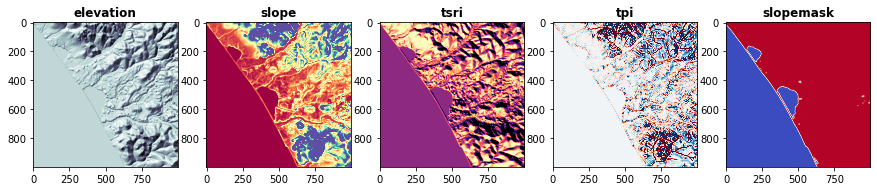

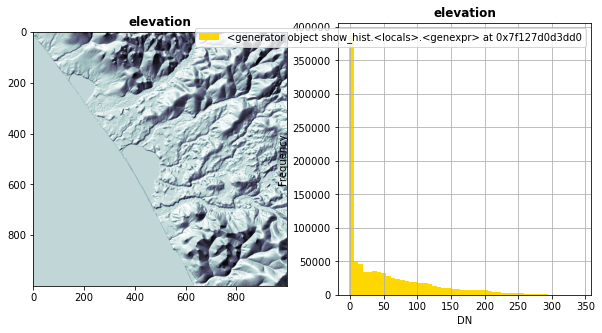

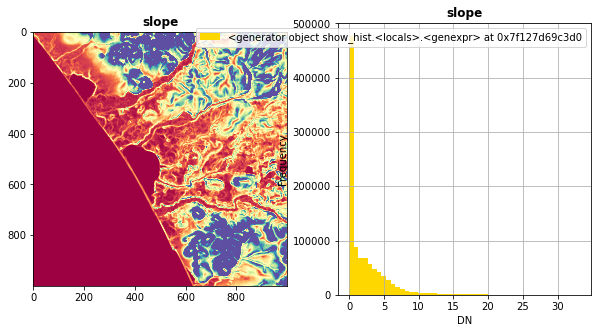

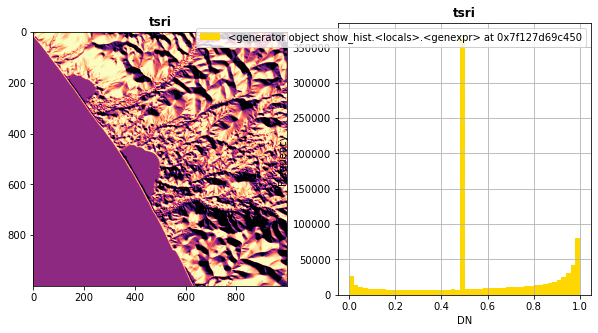

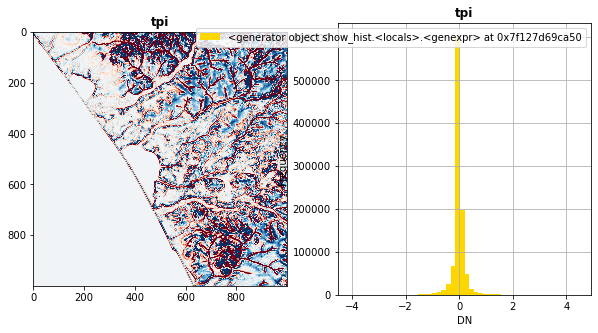

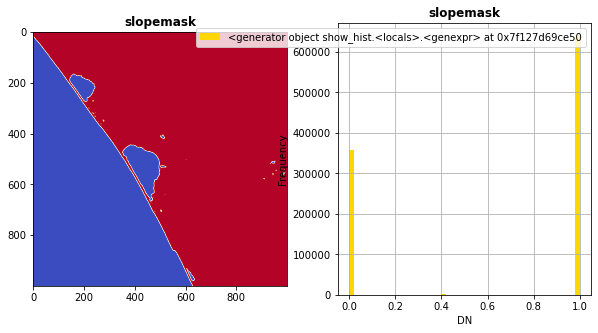

In [10]:
%%time

from rasterio.plot import show_hist

# Read back in the topo_stack_cog_fn and plot
print(topo_stack_cog_fn)
dataset = rasterio.open(topo_stack_cog_fn)
print(dataset.count)

topo_stack = dataset.read()

# This should work once you figure out the move axis of the stack: need 3 bands
n: int = len(topo_stack)
topo_cmaps = ["bone","Spectral", "magma", "RdBu", "coolwarm"]
print(topo_stack.shape)

fig, axes = plt.subplots(1,n, figsize=(n*3,5))

for i in range(n):
    
    print(topo_stack[i].min(), topo_stack[i].max())
    array_to_show = topo_stack[i]
    clims = (np.nanpercentile(topo_stack[i], 10), np.nanpercentile(topo_stack[i], 90))
    
    if 'elevation' in topo_stack_names[i]:
        #Replace elevation with its hillshade for display purposes
        array_to_show = hillshade(topo_stack[i],315,45)
        clims = None
    
    show(array_to_show, ax=axes[i], cmap=topo_cmaps[i], clim=clims, title=topo_stack_names[i])
    
    fig, (axmap, axhist) = plt.subplots(1,2, figsize=(10,5))
    show(array_to_show, ax=axmap, cmap=topo_cmaps[i], clim=clims, title=topo_stack_names[i])
    show_hist(topo_stack[i], ax=axhist, title=topo_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)


if False:
    fig, axes = plt.subplots(1,n, figsize=(n*3,30))

    for i in range(n):
        show_hist(topo_stack[i], ax=axes[i], title=topo_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)


In [11]:
#TODO add a cell reading the resulting stack in and verifying data quality with plots